# Start Install
Install kaggle-environments and gfootball dependencies, clone gfootball source and download football engine binary.

In [1]:
# %%bash
# git clone -q https://github.com/Kaggle/kaggle-environments.git
# cd kaggle-environments && pip3 install -qq . && cd ..

# apt-get -qq update
# apt-get -qq install libsdl2-gfx-dev libsdl2-ttf-dev > /dev/null

# GRF_VER=v2.7
# GRF_PATH=football/third_party/gfootball_engine/lib
# GRF_URL=https://storage.googleapis.com/gfootball/prebuilt_gameplayfootball_${GRF_VER}.so
# git clone -q -b ${GRF_VER} https://github.com/google-research/football.git
# mkdir -p ${GRF_PATH}
# wget -q ${GRF_URL} -O ${GRF_PATH}/prebuilt_gameplayfootball.so

# Add a Custom Scenario
Include a custom scenario inside the gfootball source. May be useful for quick bot testing or training. More example scenarios in the [repository](https://github.com/google-research/football/tree/master/gfootball/scenarios).

In [13]:
%%writefile /usr/local/lib/python3.6/dist-packages/gfootball/scenarios/academy_custom.py
#%%writefile /gfootball/gfootball/scenarios/academy_custom.py
#%%writefile /usr/local/lib/python3.6/dist-packages/gfootball/scenarios/academy_custom.py
from . import *

def build_scenario(builder):
  builder.config().game_duration = 300
  builder.config().deterministic = False
  builder.config().offsides = False
  builder.config().end_episode_on_score = True
  builder.config().end_episode_on_out_of_play = True
  builder.config().end_episode_on_possession_change = True
  builder.SetBallPosition(0.3, -0.05)

  builder.SetTeam(Team.e_Left)
  builder.AddPlayer(-1.0, 0.0, e_PlayerRole_GK)
  builder.AddPlayer(0.1, -0.1, e_PlayerRole_CF)

  builder.SetTeam(Team.e_Right)
  builder.AddPlayer(-1.0, 0.0, e_PlayerRole_GK)
  builder.AddPlayer(-0.7, 0.05, e_PlayerRole_CB)

Writing /usr/local/lib/python3.6/dist-packages/gfootball/scenarios/academy_custom.py


# Finish Install
Complete gfootball installation with the custom scenario included.

In [14]:
# %%bash
# cd football && GFOOTBALL_USE_PREBUILT_SO=1 pip3 install -qq . && cd ..
# rm -rf football kaggle-environments

After installation, scenario files can be modified or added in the install location.

In [15]:
!find / -name academy*.py

/usr/local/lib/python3.6/dist-packages/gfootball/scenarios/academy_empty_goal_close.py
/usr/local/lib/python3.6/dist-packages/gfootball/scenarios/academy_run_pass_and_shoot_with_keeper.py
/usr/local/lib/python3.6/dist-packages/gfootball/scenarios/academy_corner.py
/usr/local/lib/python3.6/dist-packages/gfootball/scenarios/academy_run_to_score.py
/usr/local/lib/python3.6/dist-packages/gfootball/scenarios/academy_single_goal_versus_lazy.py
/usr/local/lib/python3.6/dist-packages/gfootball/scenarios/academy_counterattack_easy.py
/usr/local/lib/python3.6/dist-packages/gfootball/scenarios/academy_counterattack_hard.py
/usr/local/lib/python3.6/dist-packages/gfootball/scenarios/academy_run_to_score_with_keeper.py
/usr/local/lib/python3.6/dist-packages/gfootball/scenarios/academy_3_vs_1_with_keeper.py
/usr/local/lib/python3.6/dist-packages/gfootball/scenarios/academy_empty_goal.py
/usr/local/lib/python3.6/dist-packages/gfootball/scenarios/academy_pass_and_shoot_with_keeper.py
/usr/local/lib/pyt

---
# Modified Template Bot
A modified version of the [Template Bot](https://www.kaggle.com/piotrstanczyk/gfootball-template-bot) with some ideas from [GFootball Rules from Environment Exploration](https://www.kaggle.com/sx2154/gfootball-rules-from-environment-exploration) and [Simple Baseline Bot](https://www.kaggle.com/eugenkeil/simple-baseline-bot).

In [16]:
%%writefile submission.py
from math import sqrt, atan2, pi
from kaggle_environments.envs.football.helpers import *

def angle(src, tgt):
    xdir = tgt[0] - src[0]
    ydir = tgt[1] - src[1]
    theta = round(atan2(xdir, -ydir) * 180 / pi, 2)
    while theta < 0:
        theta += 360
    return theta


def direction(src, tgt):
    theta = angle(src, tgt)

    if theta >= 360 - 22.5 or theta <= 0 + 22.5:
        return Action.Top
    if 45 - 22.5 <= theta <= 45 + 22.5:
        return Action.TopRight
    if 90 - 22.5 <= theta <= 90 + 22.5:
        return Action.Right
    if 135 - 22.5 <= theta <= 135 + 22.5:
        return Action.BottomRight
    if 180 - 22.5 <= theta <= 180 + 22.5:
        return Action.Bottom
    if 225 - 22.5 <= theta <= 225 + 22.5:
        return Action.BottomLeft
    if 270 - 22.5 <= theta <= 270 + 22.5:
        return Action.Left
    return Action.TopLeft

@human_readable_agent
def agent(obs):
    goal_pos = [1, 0]
    ball_pos = obs["ball"]
    
    player_pos = obs["left_team"][obs["active"]]
    player_x, player_y = player_pos
    
    ball_owned = (obs["ball_owned_team"] == 0 and 
                  obs["ball_owned_player"] == obs["active"])

    def shot(shot_dir):
        if shot_dir not in obs["sticky_actions"]:
            return shot_dir
        return Action.Shot
    
    def high_pass(pass_dir):
        if pass_dir not in obs["sticky_actions"]:
            return pass_dir
        return Action.HighPass   
    
    if  player_x < 0.6:
        if Action.Sprint not in obs['sticky_actions']:
            return Action.Sprint
    else:
        if Action.Sprint in obs['sticky_actions'] and ball_owned:
            return Action.ReleaseSprint
    
    if ball_owned:
        goal_dir = direction(player_pos, goal_pos)
        if player_x < -0.6:
            return shot(goal_dir)
        if player_x < -0.4:
            return high_pass(goal_dir)
        if player_x > 0.6:
            return shot(goal_dir)
        if player_x > 0.4 and abs(player_y) < 0.2:
            return shot(goal_dir)
        return goal_dir
        
    return direction(player_pos, ball_pos)

Writing submission.py


---
# Academy Scenarios

In [26]:
%%time

from kaggle_environments import make

scenarios = {0: "academy_custom",
             1: "academy_3_vs_1_with_keeper", 
             2: "academy_corner", 
             3: "academy_counterattack_easy", 
             4: "academy_counterattack_hard", 
             5: "academy_empty_goal", 
             6: "academy_empty_goal_close", 
             7: "academy_pass_and_shoot_with_keeper", 
             8: "academy_run_pass_and_shoot_with_keeper", 
             9: "academy_run_to_score", 
             10: "academy_run_to_score_with_keeper",
             11: "academy_single_goal_versus_lazy",
             12: "11_vs_11_kaggle"}

scenario_num = 0
env = make("football", debug=True,
           configuration={"save_video": False, 
                          "scenario_name": scenarios[scenario_num], 
                          "running_in_notebook": True})
         
output = env.run(["submission.py", "submission.py"])

scores = output[-1][0]["observation"]["players_raw"][0]["score"]
print("Scores  {0} : {1}".format(*scores))
print("Rewards {0} : {1}".format(output[-1][0]["reward"], output[-1][1]["reward"]))

Staring a new environment 218c41de-5001-4425-89d3-e701fac0a85a: with scenario: academy_custom
Resetting environment 218c41de-5001-4425-89d3-e701fac0a85a: with scenario: academy_custom
Scores  1 : 0
Rewards 1 : -1
CPU times: user 836 ms, sys: 50.7 ms, total: 886 ms
Wall time: 889 ms


In [34]:
len(output)

47

In [97]:
step_num = 20

In [98]:
output[step_num][1]['observation']['players_raw'][0]['ball']

[-0.3241942226886749, 0.04981674253940582, 0.13948781788349152]

In [86]:
#output[20]

In [66]:
import pandas as pd
import json
import numpy as np

from kaggle_environments.envs.football.helpers import Action

pd.set_option("display.float_format", lambda x: "%.5f" % x)
pd.options.display.max_rows = 999
pd.set_option('display.max_columns', 150)

np.set_printoptions(suppress=True)



# dictionary of sticky actions
sticky_actions = {
    "left": Action.Left,
    "top_left": Action.TopLeft,
    "top": Action.Top,
    "top_right": Action.TopRight,
    "right": Action.Right,
    "bottom_right": Action.BottomRight,
    "bottom": Action.Bottom,
    "bottom_left": Action.BottomLeft,
    "sprint": Action.Sprint,
    "dribble": Action.Dribble
}

action_set_dic = {
    0: 'idle',
    # movement actions (1-8)
    1: 'left', # run to the left, sticky action.
    2: 'top_left', #run to the top-left, sticky action.
    3: 'top', # run to the top, sticky action.
    4: 'top_right', # run to the top-right, sticky action.
    5: 'right', # run to the right, sticky action.
    6: 'bottom_right', # run to the bottom-right, sticky action.
    7: 'bottom', # run to the bottom, sticky action.
    8: 'bottom_left', # run to the bottom-left, sticky action
    
    # passing / shooting (9-12)
    9: 'long_pass', # perform a long pass to the player on your team. Player to pass the ball to is auto-determined based on the movement direction.
    10: 'high_pass', # perform a high pass, similar to long_pass.
    11: 'short_pass', # perform a short pass, similar to long_pass.
    12: 'shot', # perform a shot, always in the direction of the opponent's goal.
    
    13: 'sprint', # start sprinting, sticky action. Player moves faster, but has worse ball handling.
    14: 'release_direction', # reset current movement direction.
    15: 'release_sprint', # stop sprinting
    16: 'sliding', # perform a slide (effective when not having a ball)
    17: 'dribble', # start dribbling (effective when having a ball), sticky action. Player moves slower, but it is harder to take over the ball from him.
    18: 'release_dribble' # stop dribbling
}


# game_mode - current game mode, one of:
game_mode_dic = {
    0 : 'normal',
    1 : 'kickoff',
    2 : 'goalkick',
    3 : 'freekick',
    4 : 'corner',
    5 : 'throwin',
    6 : 'penalty'
}

# player roles
player_role_dic = {
    0: 'GK',
    1: 'CB',
    2: 'LB',
    3: 'RB',
    4: 'DM',
    5: 'CM',
    6: 'LM',
    7: 'RM',
    8: 'AM',
    9: 'CF'
}


def do_flatten(obj):
    if type(obj) == list:
        return np.array(obj).flatten()
    return obj.flatten()

def convert_observation(observation, fixed_positions=False):

    final_obs = []
    
    for obs in observation:

        o = []
        if fixed_positions:
            for i, name in enumerate(['left_team', 'left_team_direction',
                                    'right_team', 'right_team_direction']):
                o.extend(do_flatten(obs[name]))
            # If there were less than 11vs11 players we backfill missing values
            # with -1.
            if len(o) < (i + 1) * 22:
                o.extend([-1] * ((i + 1) * 22 - len(o)))
        else:
            o.extend(do_flatten(obs['left_team']))
            o.extend(do_flatten(obs['left_team_direction']))
            o.extend(do_flatten(obs['right_team']))
            o.extend(do_flatten(obs['right_team_direction']))

        # If there were less than 11vs11 players we backfill missing values with
        # -1.
        # 88 = 11 (players) * 2 (teams) * 2 (positions & directions) * 2 (x & y)
        if len(o) < 88:
            o.extend([-1] * (88 - len(o)))

        # ball position
        o.extend(obs['ball'])
        # ball direction
        o.extend(obs['ball_direction'])
        # one hot encoding of which team owns the ball
        if obs['ball_owned_team'] == -1:
            o.extend([1, 0, 0])
        if obs['ball_owned_team'] == 0:
            o.extend([0, 1, 0])
        if obs['ball_owned_team'] == 1:
            o.extend([0, 0, 1])

        active = [0] * 11
        if obs['active'] != -1:
            active[obs['active']] = 1
        o.extend(active)

        game_mode = [0] * 7
        game_mode[obs['game_mode']] = 1
        o.extend(game_mode)
        final_obs.append(o)

        return np.array(final_obs, dtype=np.float32).flatten()

    
def get_episode_simple115_v2_df(team_want, episode_id, episode_dir):
    # get json file for specific episode
    epsiode_full_dir = '{0}{1}.json'.format(episode_dir, episode_id)
    epsiode_full_dir

    with open(epsiode_full_dir) as json_file:
        obs = json.load(json_file)
        
    lteam = obs['info']['TeamNames'][0]
    rteam = obs['info']['TeamNames'][1]
    # want to get left or right based on agent
    if team_want ==  lteam:
        lr_index = 0
    else:
        lr_index = 1

    # want to get left or right based on agent
    if team_want ==  lteam:
        lr_index = 0
    else:
        lr_index = 1

    
    df = get_simple115_v2_df(obs)
    
    return df    


def get_simple115_v2_df(output):
    steps = output
    obs_list = []
    for step_num in range(len(steps)):
        observation = [steps[step_num][0]['observation']['players_raw'][0]]
        v2_115_obs = convert_observation(observation)
        obs_list.append(v2_115_obs)
       
    df_cols = get_simple115_v2_df_cols()
    df = pd.DataFrame(obs_list, columns=df_cols)
    return df



def get_simple115_v2_df_cols():
        # coords of left_team players (22)
    lcoords_col = []
    for i in range(11):
        lcoords_col.append('l_x' + str(i))
        lcoords_col.append('l_y' + str(i))
    # direction of left_team players (22)
    ldirs_col = []
    for i in range(11):
        ldirs_col.append('l_x_dir' + str(i))
        ldirs_col.append('l_y_dir' + str(i))
    # coords of right_team players (22)
    rcoords_col = []
    for i in range(11):
        rcoords_col.append('r_x' + str(i))
        rcoords_col.append('r_y' + str(i))
    # direction of left_team players (22)
    rdirs_col = []
    for i in range(11):
        rdirs_col.append('r_x_dir' + str(i))
        rdirs_col.append('r_y_dir' + str(i))
    # ball position (x,y,z)
    ball_pos = ['ball_x_pos', 'ball_y_pos', 'ball_z_pos']
    # ball direction (x,y,z)
    ball_dir = ['ball_x_dir', 'ball_y_dir', 'ball_z_dir']
    # one hot encoding of ball ownership (noone, left, right) (3)
    ball_own = ['ball_own_noone', 'ball_own_left', 'ball_own_right']
    # one hot encoding of which player is active (11)
    player_actives = ['p_active' + str(x) for x in range(11)]
    # one hot encoding of game mode (7)
    game_modes = ['gmode' + str(x) for x in range(7)]

    final_col_list = lcoords_col + ldirs_col + rcoords_col + rdirs_col + ball_pos + \
        ball_dir + ball_own + player_actives + game_modes
    
    return final_col_list


def get_basic_df(output):
    steps = output
    steps_lists = []

    for step_num in range(len(steps)):
        #print(i)
        step = steps[step_num]
        # get left or right player based on if matches team we want
        obs_step = step[0]

        if step_num == 0:
            action = None
            action_str = None
        else:
            action = obs_step['action'][0]
            action_str = action_set_dic[action]


        status = obs_step['status']
        observation = obs_step['observation']
        players_raw = observation['players_raw'][0]

        active_player = players_raw['active']

        game_mode = players_raw['game_mode']
        game_mode_str = game_mode_dic[game_mode]

        # score
        left_score = players_raw['score'][0]
        right_score = players_raw['score'][1]

        # steps
        steps_left = players_raw['steps_left']

        # ball owned team  {-1, 0, 1}, -1 = ball not owned, 0 = left team, 1 = right team.
        ball_owned_team = players_raw['ball_owned_team']
        # we need to map ball owned based on if left or right agent
        if ball_owned_team == -1:
            off_def_flag = 'none'
        elif ball_owned_team == 0:
            off_def_flag = 'offense'
        elif ball_owned_team == 1:
            off_def_flag = 'defense'

        # now create dataframe
        step_list = [step_num, action, action_str, game_mode_str, active_player, off_def_flag, left_score, right_score]
        steps_lists.append(step_list)


    df_columns = ['step_num', 'action', 'action_str', 'game_mode_str', 'active_player', 'off_def_flag', 'left_score', 'right_score']
    basic_df = pd.DataFrame(steps_lists, columns = df_columns)
    return basic_df


def get_all_df(output):
    basic_df = get_basic_df(output)
    
    # get sidmple115_v2 embed df
    s115_df = get_simple115_v2_df(output)
    s115_df['step_num'] = range(0, len(basic_df))
    
    #merge
    final_df = pd.merge(basic_df, s115_df, how='outer', on=['step_num'])
    return final_df

In [96]:
output[step_num][1]['observation']['players_raw'][0]['ball']

[-0.3241942226886749, 0.04981674253940582, 0.13948781788349152]

In [46]:
len(output)

47

In [68]:
final_df = get_all_df(output)

In [88]:
final_df.head(2)

,step_num,action,action_str,game_mode_str,active_player,off_def_flag,left_score,right_score,l_x0,l_y0,l_x1,l_y1,l_x2,l_y2,l_x3,l_y3,l_x4,l_y4,l_x5,l_y5,l_x6,l_y6,l_x7,l_y7,l_x8,l_y8,l_x9,l_y9,l_x10,l_y10,l_x_dir0,l_y_dir0,l_x_dir1,l_y_dir1,l_x_dir2,l_y_dir2,l_x_dir3,l_y_dir3,l_x_dir4,l_y_dir4,l_x_dir5,l_y_dir5,l_x_dir6,l_y_dir6,l_x_dir7,l_y_dir7,l_x_dir8,l_y_dir8,l_x_dir9,l_y_dir9,l_x_dir10,l_y_dir10,r_x0,r_y0,r_x1,r_y1,r_x2,r_y2,r_x3,r_y3,r_x4,r_y4,r_x5,r_y5,r_x6,r_y6,r_x7,r_y7,r_x8,r_y8,r_x9,r_y9,r_x10,r_y10,r_x_dir0,r_y_dir0,r_x_dir1,r_y_dir1,r_x_dir2,r_y_dir2,r_x_dir3,r_y_dir3,r_x_dir4,r_y_dir4,r_x_dir5,r_y_dir5,r_x_dir6,r_y_dir6,r_x_dir7,r_y_dir7,r_x_dir8,r_y_dir8,r_x_dir9,r_y_dir9,r_x_dir10,r_y_dir10,ball_x_pos,ball_y_pos,ball_z_pos,ball_x_dir,ball_y_dir,ball_z_dir,ball_own_noone,ball_own_left,ball_own_right,p_active0,p_active1,p_active2,p_active3,p_active4,p_active5,p_active6,p_active7,p_active8,p_active9,p_active10,gmode0,gmode1,gmode2,gmode3,gmode4,gmode5,gmode6
0,0,nan,None,normal,0,none,0,0,-1.01103,-0.00000,0.10110,-0.10163,0.00000,-0.00000,0.00000,-0.00000,1.01103,0.00000,0.70772,-0.05081,-0.00000,0.00000,-0.00000,0.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,0.30000,-0.05000,0.11062,-0.00000,0.00000,0.00616,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,1,13.00000,sprint,normal,1,none,0,0,-1.00935,-0.00005,0.10338,-0.10104,0.00358,-0.00011,0.00366,0.00095,1.01103,0.00000,0.70624,-0.04982,-0.00000,0.00000,-0.00243,0.00166,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,0.30000,-0.05000,0.11060,-0.00000,0.00000,-0.00192,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [ ]:
np.r_

In [85]:
final_df.iloc[:,np.r_[0,2,4,5,10:12]].iloc[20:47]

,step_num,action_str,active_player,off_def_flag,l_x1,l_y1
20,20,right,1,offense,0.30870,-0.05194
21,21,right,1,offense,0.32124,-0.05160
22,22,right,1,offense,0.33392,-0.05129
23,23,right,1,offense,0.34702,-0.05088
24,24,right,1,offense,0.36015,-0.05042
25,25,right,1,offense,0.37359,-0.05017
26,26,right,1,offense,0.38724,-0.05012
27,27,right,1,offense,0.40074,-0.05005
28,28,shot,1,offense,0.41427,-0.05001
29,29,shot,1,offense,0.42802,-0.04994


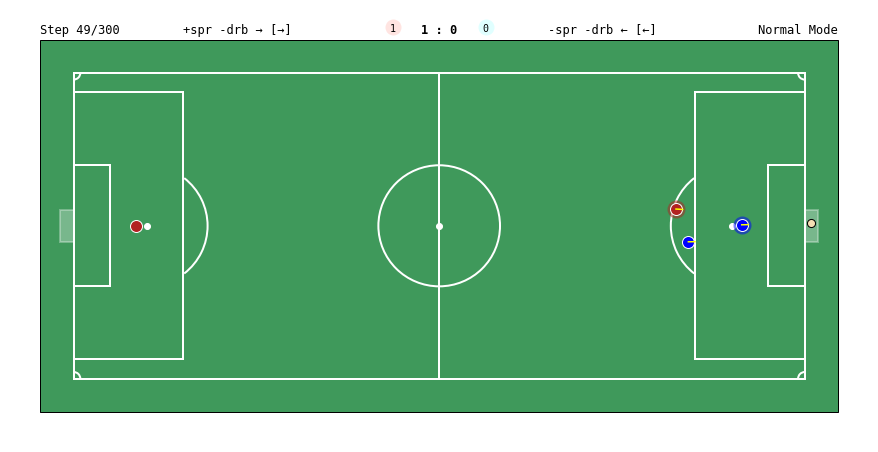

In [25]:
viz = visualize(output)
HTML(viz.to_html5_video())

---
# Visualization

This animation is created using the beautiful tutorial from [Human Readable Visualization](https://www.kaggle.com/jaronmichal/human-readable-visualization).

In [61]:
from IPython.display import HTML
from visualizer import visualize
#viz = visualize(output)